### Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Define Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets
- Perform PCA on Encoded Data
- Evaluate generated data on classification models

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [3]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [4]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))


In [5]:
# Check Shape of data
print(X_train_norm.head())
print(X_train_norm.shape)
print(np.array(X_train_norm)[:5])
# 21 features that we are going to try to reduce.

         0         1         2         3         4         5         6   \
0  0.277778  0.000000  0.001773  0.176471  0.733333  0.279412  0.000000   
1  0.666667  0.038462  0.000000  0.294118  0.426667  0.073529  0.439560   
2  0.388889  0.500000  0.000000  0.588235  0.546667  0.367647  0.000000   
3  0.592593  0.461538  0.000000  0.294118  0.520000  0.102941  0.000000   
4  0.722222  0.000000  0.000000  0.058824  0.506667  0.073529  0.186813   

         7       8    9   ...        11        12        13        14     15  \
0  0.000000  0.6875  1.0  ...  0.559322  0.045872  0.301724  0.222222  0.125   
1  0.140039  0.0000  0.0  ...  0.141243  0.733945  0.310345  0.166667  0.000   
2  0.084813  0.1250  0.0  ...  0.610169  0.192661  0.517241  0.333333  0.125   
3  0.011834  0.0000  0.0  ...  0.259887  0.660550  0.422414  0.111111  0.000   
4  0.143984  0.0000  0.0  ...  0.220339  0.688073  0.387931  0.444444  0.000   

         16        17        18        19   20  
0  0.055118  0.0733

_____________________________
### PCA

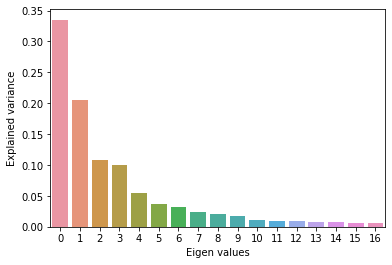

0.992949263633176

In [6]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca = PCA(n_components = 17)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

x_pca_train_labeled = np.c_[X_train_pca , y_train]
x_pca_test_labeled = np.c_[X_test_pca , y_test]

sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

pca.explained_variance_ratio_.sum()

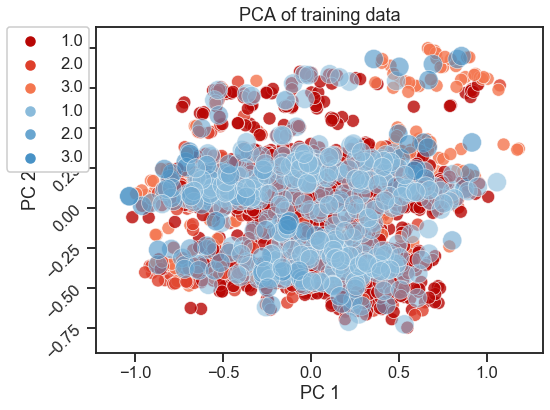

In [9]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot()
sns.scatterplot(x=x_pca_train_labeled[:,0], 
                y=x_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=x_pca_train_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_labeled[:,0],
                y=x_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=x_pca_test_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (8,6) )
ax1.set_title("PCA of training data")
plt.yticks(rotation=45) 
plt.show()

__________________________________________
### Autoencoder

In [10]:
## Definition of Auxiliar functions: loss function, gradient function and model training function
from typing import List

def loss(x: np.ndarray, x_bar: np.ndarray) -> float:
    return tf.losses.mean_squared_error(x, x_bar)

def grad(model: keras.models.Model, inputs: np.ndarray):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction

def train_model(model: keras.models.Model, inputs: pd.DataFrame, num_epochs: int, batch_size: int):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    x_train = np.array(inputs)

    for epoch in range(num_epochs):
        for x in range(0, len(x_train), batch_size):
            x_inp = x_train[x : x + batch_size]
            loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print("Step: {},Loss: {}".format(epoch, sum(loss(inputs_reshaped, reconstruction)/batch_size).numpy()))

In [ ]:
# Define Autoencoder
class ComposeAutoEncoder(keras.models.Model):
    def __init__(self):
        super(ComposeAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 16  # 21/16 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(64, activation='relu')(self.flatten_input)
        self.encoder2 = layers.Dense(32, activation='relu')(self.encoder1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded (32-dimensional) input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(32, activation='relu')(self.encoded_input)
        self.decoder2 = layers.Dense(64, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder1)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [ ]:
# Instantiate and train model
autoencoder = ComposeAutoEncoder()
train_model(autoencoder, X_train_norm, num_epochs=100, batch_size=400)

In [11]:
# Define Simple Autoencoder One-layered encoder and decoder
class SimpleAutoEncoder(keras.models.Model):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 8  # 21/8 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(16, activation='relu')(self.flatten_input)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder1)
        
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(16, activation='relu')(self.encoded_input)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder1)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [12]:
# Define Simple Autoencoder One-layered encoder and decoder
class ComplexAutoEncoder(keras.models.Model):
    def __init__(self):
        super(ComplexAutoEncoder, self).__init__()
        
        # this is the size of our encoded representations
        encoding_dim = 8  # 21/8 - we will try to reduce the dimensions to this number.
        # this is our input placeholder
        input_features = layers.Input(shape=(21))

        self.flatten_input = layers.Flatten()(input_features)
        # "Encoder layers"
        self.encoder1 = layers.Dense(16, activation='relu')(self.flatten_input)
        self.batch_norm1 = layers.BatchNormalization()(self.encoder1)
        self.encoder2 = layers.Dense(12, activation='relu')(self.batch_norm1)
        # "Encoder output" - "bottleneck"
        self.bottleneck = layers.Dense(encoding_dim, activation='relu')(self.encoder2)
        
        # this model maps an input to its encoded representation
        self.encoder = keras.models.Model(input_features, self.bottleneck, name='encoder')

        # "Decoder layers"
        # create a placeholder for an encoded input
        self.encoded_input = layers.Input(shape=(encoding_dim,))
        self.decoder1 = layers.Dense(12, activation='relu')(self.encoded_input)
        self.decoder2 = layers.Dense(16, activation='relu')(self.decoder1)
        # "decoded" is the lossy reconstruction of the input
        self.decoded = layers.Dense(21, activation='sigmoid')(self.decoder2)
        # create the decoder model
        self.decoder = keras.models.Model(self.encoded_input, self.decoded, name='decoder')

    
    def call(self, inp):
        # full autoencoder for training
        encoder_model = self.encoder(inp)
        decoder_model = self.decoder(encoder_model)

        return decoder_model, inp

In [13]:
# Train Autoencoders
simple_autoencoder = SimpleAutoEncoder()
train_model(simple_autoencoder, X_train_norm, num_epochs=100, batch_size=400)
complex_autoencoder = ComplexAutoEncoder()
train_model(complex_autoencoder, X_train_norm, num_epochs=100, batch_size=400)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0,Loss: 0.03159160912036896
Step: 1,Loss: 0.031008673831820488
Step: 2,Loss: 0.030476877465844154
Step: 3,Loss: 0.030038123950362206
Step: 4,Loss: 0.02964106760919094
Step: 5,Loss: 0.029222209006547928
Step: 6,Loss: 0.028737515211105347
Step: 7,Loss: 0.028168262913823128
Step: 8,Loss: 0.027503475546836853
Step: 9,Loss: 0.026733536273241043
Step: 10,Loss: 0.025851013138890266
Step: 11,Loss: 0.024842308834195137
Step: 12,Loss: 0.023699745535850525
Step: 13,Loss: 0.02241886407136917
Step: 14,Loss: 0.

In [14]:
simple_predictions = simple_autoencoder.predict(np.array(X_test_norm))
complex_predictions = complex_autoencoder.predict(np.array(X_test_norm))

In [127]:
# Analyze values of a few features
simple_predictions_dataframe = pd.DataFrame(simple_predictions[0])
complex_predictions_dataframe = pd.DataFrame(complex_predictions[0])
original_dataframe = pd.DataFrame(simple_predictions[1])
print(simple_predictions_dataframe.iloc[:,:5].describe())
print(complex_predictions_dataframe.iloc[:,:5].describe())
print(original_dataframe.iloc[:,:5].describe())

                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.524272    0.092276    0.023560    0.158345    0.485162
std      0.107057    0.031756    0.019367    0.039988    0.097942
min      0.246869    0.032874    0.002093    0.081801    0.271576
25%      0.454401    0.065621    0.008822    0.129176    0.407419
50%      0.518108    0.092878    0.016730    0.151065    0.477108
75%      0.587198    0.114429    0.032048    0.186522    0.550592
max      0.832492    0.178245    0.107834    0.286627    0.735315
                0           1           2           3           4
count  426.000000  426.000000  426.000000  426.000000  426.000000
mean     0.532686    0.091836    0.004171    0.154054    0.478263
std      0.092940    0.050825    0.009326    0.057414    0.120307
min      0.360695    0.012693    0.000006    0.030510    0.328005
25%      0.462424    0.057117    0.000192    0.119785    0.381763
50%      0

In [111]:
sum(loss(predictions[1], predictions[0]))/len(predictions[1])

<tf.Tensor: id=471853, shape=(), dtype=float32, numpy=0.011729969>

In [128]:
## Encode Train and Test Data
simple_encoded_train = simple_autoencoder.encoder.predict(X_train_norm)
simple_encoded_test = simple_autoencoder.encoder.predict(X_test_norm)
complex_encoded_train = complex_autoencoder.encoder.predict(X_train_norm)
complex_encoded_test = complex_autoencoder.encoder.predict(X_test_norm)
# Renormalize input
scaler = MinMaxScaler()
simple_encoded_train = pd.DataFrame(scaler.fit_transform(simple_encoded_train))
simple_encoded_test = pd.DataFrame(scaler.transform(simple_encoded_test))
complex_encoded_train = pd.DataFrame(scaler.fit_transform(complex_encoded_train))
complex_encoded_test = pd.DataFrame(scaler.transform(complex_encoded_test))

______________________________________
### PCA on encoded data

In [146]:
pca = PCA(n_components=4)
simple_encoded_pca_train = pca.fit_transform(simple_encoded_train)
simple_encoded_pca_test = pca.transform(simple_encoded_test)

c_pca = PCA(n_components=4)
complex_encoded_pca_train = c_pca.fit_transform(complex_encoded_train)
complex_encoded_pca_test = c_pca.transform(complex_encoded_test)

simple_encoded_pca_train_labeled = np.c_[simple_encoded_pca_train , y_train]
simple_encoded_pca_test_labeled = np.c_[simple_encoded_pca_test , y_test]
complex_encoded_pca_train_labeled = np.c_[complex_encoded_pca_train , y_train]
complex_encoded_pca_test_labeled = np.c_[complex_encoded_pca_test , y_test]

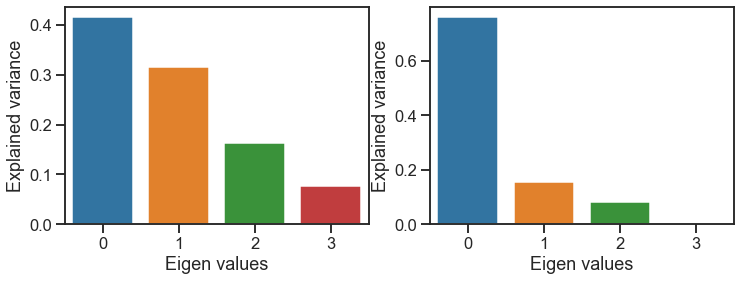

Simple PCA explained variance ratio: 0.969541603570595
Simple PCA explained variance ratio: 0.999999999999999


In [147]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sns.barplot(np.arange(np.shape(pca.explained_variance_ratio_)[0]),pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

ax1 = plt.subplot(1,2,2)
sns.barplot(np.arange(np.shape(c_pca.explained_variance_ratio_)[0]),c_pca.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(f"Simple PCA explained variance ratio: {pca.explained_variance_ratio_.sum()}")
print(f"Simple PCA explained variance ratio: {c_pca.explained_variance_ratio_.sum()}")

In [1]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=simple_encoded_pca_train_labeled[:,0], 
                y=simple_encoded_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=simple_encoded_pca_train_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=simple_encoded_pca_test_labeled[:,0],
                y=simple_encoded_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=simple_encoded_pca_test_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Simple AE)")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=complex_encoded_pca_train_labeled[:,0], 
                y=complex_encoded_pca_train_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=complex_encoded_pca_train_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=complex_encoded_pca_test_labeled[:,0],
                y=complex_encoded_pca_test_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=complex_encoded_pca_test_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Complex AE)")

plt.yticks(rotation=45) 
plt.show()

NameError: name 'sns' is not defined

______________________
### DNN Classifier

In [34]:
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

In [174]:
## Test the encoded input on the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [175]:
# Fit best model with original dimension data
best_model = build_best_model(0.00001, len(X_train_norm.keys()))
history = best_model.fit(X_train_norm, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist = pd.DataFrame(history.history)

test_loss, test_acc = best_model.evaluate(X_test_norm, y_test_oh)

# Fit best model with reduced dimension data
encoded_model = build_best_model(0.00001, len(encoded_train.keys()))
history_encoded = encoded_model.fit(encoded_train, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
hist_encoded = pd.DataFrame(history_encoded.history)

test_loss, test_acc = encoded_model.evaluate(encoded_test, y_test_oh)

426/426 [==============================] - 0s 152us/sample - loss: 0.3152 - accuracy: 0.8756


### Differences:
##### 1- original data=0.9272 ; reduced data= 0.8545
##### 2- original data=0.9178 ; reduced data= 0.8568
##### 3- original data=0.9249 ; reduced data= 0.8545